import netCDF4
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib


import matplotlib.tri as tri
from matplotlib.colors import ListedColormap
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
#from sklearn.mixture import GaussianMixture
#from clustering_concentration import *
def quatplot(y, z, quadrangles, values, ax=None, **kwargs):
    if not ax: ax = plt.gca()
    yz = np.c_[y,z]
    verts = yz[quadrangles]
    pc = matplotlib.collections.PolyCollection(verts, **kwargs)
    pc.set_array(values)
    ax.add_collection(pc)
    ax.autoscale()
    return pc



def showEltPlot(nodes, elements, values, titlelabel=[""], size=[5, 5], ax=None, p_ext=[0.2, 0.2],
                colormap='viridis', e_notation=False, assign_bar_range=[], 
                x_unit=r'x (m)', y_unit=r'y (m)',font_adjust=1.8):

    y = nodes[:, 0]
    z = nodes[:, 1]
    size_factor=np.array(size).mean()*font_adjust
    if ax is None:
        fig, ax = plt.subplots(dpi=144, figsize=(size[0], size[1]))
    else:
        fig = ax.figure
    ax.set_aspect('equal')

    # 設定色階範圍
    if assign_bar_range:
        vmin, vmax = assign_bar_range
    else:
        vmin, vmax = values.min(), values.max()

    # 畫主圖
    pc = quatplot(y, z, np.asarray(elements), values, ax=ax,
                  edgecolor='face', cmap=colormap)
    pc.set_clim(vmin, vmax)
    # 軸範圍設定
    x_min, x_max = y.min(), y.max()
    y_min, y_max = z.min(), z.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min - x_range * p_ext[0], x_max + x_range * p_ext[0])
    ax.set_ylim(y_min - y_range * p_ext[1], y_max + y_range * p_ext[1])


    # 加 colorbar（這之後才能設定 ticks）
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cbar = fig.colorbar(pc, cax=cax, fraction=0.046, pad=0.04)

    # 設定 ticks
    ticks = np.linspace(vmin, vmax, 6)
    cbar.set_ticks(ticks)
    if e_notation:
        cbar.set_ticklabels([f"{tick:.2e}" for tick in ticks],fontsize=size_factor)
    else:
        cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks],fontsize=size_factor)
    cbar.set_label(titlelabel[-1], rotation=270, labelpad=15)

    # 標題與軸標籤
    
    ax.set_title(titlelabel[0],fontsize=1.5*size_factor)
    ax.set_xlabel(x_unit,fontsize=size_factor)
    ax.set_ylabel(y_unit,fontsize=size_factor)
    ax.tick_params(axis='x', labelsize=size_factor)
    ax.tick_params(axis='y', labelsize=size_factor)
    return fig, ax, cbar



def showNodePlot(nodes, elements, nodal_values, titlelabel=[""], size=[5, 5], ax=None, p_ext=[0.2, 0.2], 
                 colormap='viridis', e_notation=False, assign_bar_range=[],
                 x_unit=r'x (m)', y_unit=r'y (m)', font_adjust=1.8, levels_num=200, show_cbar=True):

    y = nodes[:, 0]
    z = nodes[:, 1]
    size_factor = np.array(size).mean() * font_adjust

    if ax is None:
        fig, ax = plt.subplots(dpi=144, figsize=(size[0], size[1]))
    else:
        fig = ax.figure
    ax.set_aspect('equal')

    def quads_to_tris(quads):
        tris = []
        for n0, n1, n2, n3 in quads:
            tris.append([n0, n1, n2])
            tris.append([n2, n3, n0])
        return tris

    elements_all_tris = quads_to_tris(elements)
    triangulation = tri.Triangulation(y, z, elements_all_tris)

    # 設定色階範圍
    if assign_bar_range:
        vmin, vmax = assign_bar_range
    else:
        vmin, vmax = nodal_values.min(), nodal_values.max()
    vmin, vmax = vmin * 0.99999, vmax * 1.00001
    levels = np.linspace(vmin, vmax, levels_num)

    # 主圖
    pc = ax.tricontourf(triangulation, nodal_values, levels=levels, cmap=colormap, vmin=vmin, vmax=vmax)

    # 軸範圍
    x_min, x_max = y.min(), y.max()
    y_min, y_max = z.min(), z.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min - x_range * p_ext[0], x_max + x_range * p_ext[0])
    ax.set_ylim(y_min - y_range * p_ext[1], y_max + y_range * p_ext[1])

    cbar = None
    if show_cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.1)
        cbar = fig.colorbar(pc, cax=cax)
        ticks = np.linspace(vmin, vmax, 6)
        cbar.set_ticks(ticks)
        if e_notation:
            cbar.set_ticklabels([f"{tick:.2e}" for tick in ticks], fontsize=size_factor)
        else:
            cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks], fontsize=size_factor)
        cbar.set_label(titlelabel[-1], rotation=270, labelpad=15)

    # 標題與軸標籤
    ax.set_title(titlelabel[0], fontsize=1.5 * size_factor)
    ax.set_xlabel(x_unit, fontsize=size_factor)
    ax.set_ylabel(y_unit, fontsize=size_factor)
    ax.tick_params(axis='x', labelsize=size_factor)
    ax.tick_params(axis='y', labelsize=size_factor)

    return fig, ax, cbar





def read_vars(e_name, node_variable_idx, element_variable_idx):
    nc = netCDF4.Dataset(e_name)
    var_keys=list(nc.variables.keys())
    print(var_keys)
    #Load coordinates
    coord_str=[k for k in var_keys if "coord" in k]
    coords=[np.array(nc.variables[k]) for k in coord_str]
    nodes=np.stack(coords).T
    times=np.array(nc.variables['time_whole'])
    #Deal with connectivity
    all_connect_str=[k for k in var_keys if "connect" in k]
    connect_components=[np.array(nc.variables[k])-1 for k in all_connect_str]
    global_connection=np.vstack([cp for cp in connect_components])

    #Extract element_quantities
    elet_block_num=len(all_connect_str)
    element_blocks_var_keys=[]
    for ebid in range(elet_block_num):
        element_blocks_var_keys.append(["vals_elem_var"+str(idx)+"eb"+str(ebid+1) for idx in element_variable_idx])
    element_blocks_var_quantities=[]
    for ebid in range(elet_block_num):
        element_blocks_var_quantities.append([np.array(nc.variables[k]) for k in element_blocks_var_keys[ebid]])
    elet_vars=[]
    for var_idx in range(len(element_variable_idx)):
        quant=np.array([])
        for ebid in range(elet_block_num):
            data= element_blocks_var_quantities[ebid][var_idx]
            quant=np.hstack([quant,data ]) if quant.size else data
        elet_vars.append(quant)

    #Extract nodal variables
    nodal_var_keys=["vals_nod_var"+str(idx) for idx in node_variable_idx]
    node_vars=[np.array(nc.variables[k]) for k in nodal_var_keys]
    return nodes, connect_components, global_connection, node_vars, elet_vars,times

# I. Load data from .e

In [1]:
from read_fem import *

In [2]:
def read_prestress():

    node_variable_idx=[1,2]
    node_var_labels=[
                    [r"Displacement $u_x$(m)",""],
                    [r"Displacement $u_y$(m)",""]]
    element_variable_idx=[4,6]
    elt_var_labels=[[r"Stress $\sigma_{xx}$(MPa)", ""],
                    [r"Stress $\sigma_{yy}$(MPa)", ""],]
    _, _, _, _, elet_vars1,times1=read_vars('Eigen_strain/negative_model2.e', node_variable_idx, element_variable_idx)
    _, _, _, _, elet_vars2,times2=read_vars('Eigen_strain/none_model2.e', node_variable_idx, element_variable_idx)
    pre_stress=[elet_vars1[i]-elet_vars2[i] for i in range(len(node_variable_idx))]
    #gravity = [elet_vars2[-1]]
    return pre_stress

In [3]:
output_list_no_defects=['simulation_files2/No_defects.e']
output_list_weak_Gc=['simulation_files2/No1_0p95_2.e','simulation_files2/No2_0p98_2.e']
output_list_initd=['simulation_files2/No1_inidR0p05_2.e','simulation_files2/No2_inidR0p02_2.e']
e_name=output_list_no_defects[0]
pre_stress=read_prestress()

['time_whole', 'eb_status', 'eb_prop1', 'ns_status', 'ns_prop1', 'ss_status', 'ss_prop1', 'coordx', 'coordy', 'eb_names', 'ns_names', 'ss_names', 'coor_names', 'node_num_map', 'connect1', 'connect2', 'elem_num_map', 'elem_ss1', 'side_ss1', 'elem_ss2', 'side_ss2', 'elem_ss3', 'side_ss3', 'elem_ss4', 'side_ss4', 'elem_ss5', 'side_ss5', 'node_ns1', 'node_ns2', 'node_ns3', 'node_ns4', 'node_ns5', 'name_nod_var', 'vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'name_elem_var', 'vals_elem_var1eb1', 'vals_elem_var2eb1', 'vals_elem_var3eb1', 'vals_elem_var4eb1', 'vals_elem_var5eb1', 'vals_elem_var6eb1', 'vals_elem_var7eb1', 'vals_elem_var8eb1', 'vals_elem_var9eb1', 'vals_elem_var10eb1', 'vals_elem_var11eb1', 'vals_elem_var12eb1', 'vals_elem_var13eb1', 'vals_elem_var14eb1', 'vals_elem_var15eb1', 'vals_elem_var1eb2', 'vals_elem_var2eb2', 'vals_elem_var3eb2', 'vals_elem_var4eb2', 'vals_elem_var5eb2', 'vals_elem_var6eb2', 'vals_elem_var7eb2', 'vals_elem_var8eb2', 'vals_elem_var9eb2', 'vals_elem

In [4]:

node_variable_idx=[1]
node_var_labels=[[r"Temperature $\theta\;(^{\circ}C)$", ""],]
element_variable_idx=[2,11,]#12]
elt_var_labels=[[r"Thermal Expansion $\alpha_{t}(x,y)(^{\circ}$C$^{-1}$)", ""],
                 [r"Reference Temperature $\theta_{ref}(x,y)\;(^{\circ}C$)", ""],
                ]#[r"Eigen Strain $\epsilon_{eig}$", r""],]


In [5]:
nodes, connect_components, global_connection, node_vars, elet_vars,times=read_vars(e_name, node_variable_idx, element_variable_idx)
# add pre stress
elet_vars+=pre_stress
elt_var_labels+=[[r"Pre-Stress $\sigma_{pre(xx)}$(MPa)", r""],
                 [r"Pre-Stress $\sigma_{pre(yy)}$(MPa)", r""]]

['time_whole', 'eb_status', 'eb_prop1', 'ns_status', 'ns_prop1', 'ss_status', 'ss_prop1', 'coordx', 'coordy', 'eb_names', 'ns_names', 'ss_names', 'coor_names', 'node_num_map', 'connect1', 'connect2', 'elem_num_map', 'elem_ss1', 'side_ss1', 'elem_ss2', 'side_ss2', 'elem_ss3', 'side_ss3', 'elem_ss4', 'side_ss4', 'elem_ss5', 'side_ss5', 'node_ns1', 'node_ns2', 'node_ns3', 'node_ns4', 'node_ns5', 'name_nod_var', 'vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'name_elem_var', 'vals_elem_var1eb1', 'vals_elem_var2eb1', 'vals_elem_var3eb1', 'vals_elem_var4eb1', 'vals_elem_var5eb1', 'vals_elem_var6eb1', 'vals_elem_var7eb1', 'vals_elem_var8eb1', 'vals_elem_var9eb1', 'vals_elem_var10eb1', 'vals_elem_var11eb1', 'vals_elem_var12eb1', 'vals_elem_var13eb1', 'vals_elem_var14eb1', 'vals_elem_var15eb1', 'vals_elem_var16eb1', 'vals_elem_var17eb1', 'vals_elem_var18eb1', 'vals_elem_var19eb1', 'vals_elem_var20eb1', 'vals_elem_var21eb1', 'vals_elem_var22eb1', 'vals_elem_var23eb1', 'vals_

(<Figure size 864x864 with 2 Axes>,
 <Axes: title={'center': 'Reference Temperature $\\theta_{ref}(x,y)\\;(^{\\circ}C$)'}, xlabel='x (m)', ylabel='y (m)'>,
 <matplotlib.colorbar.Colorbar at 0x23987044d10>)

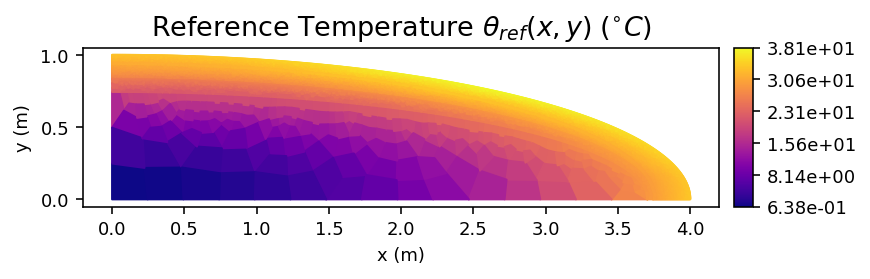

In [6]:
step=0
param_idx=1
vmax=elet_vars[param_idx].max()
vmin=elet_vars[param_idx].min()
showEltPlot(nodes,  global_connection, elet_vars[param_idx][step], titlelabel=[elt_var_labels[param_idx][0],elt_var_labels[param_idx][1]], size=[6, 6], ax=None, p_ext=[0.05, 0.05],
                colormap='plasma', e_notation=True, assign_bar_range=[vmin,vmax], 
                x_unit=r'x (m)', y_unit=r'y (m)',font_adjust=1.5)

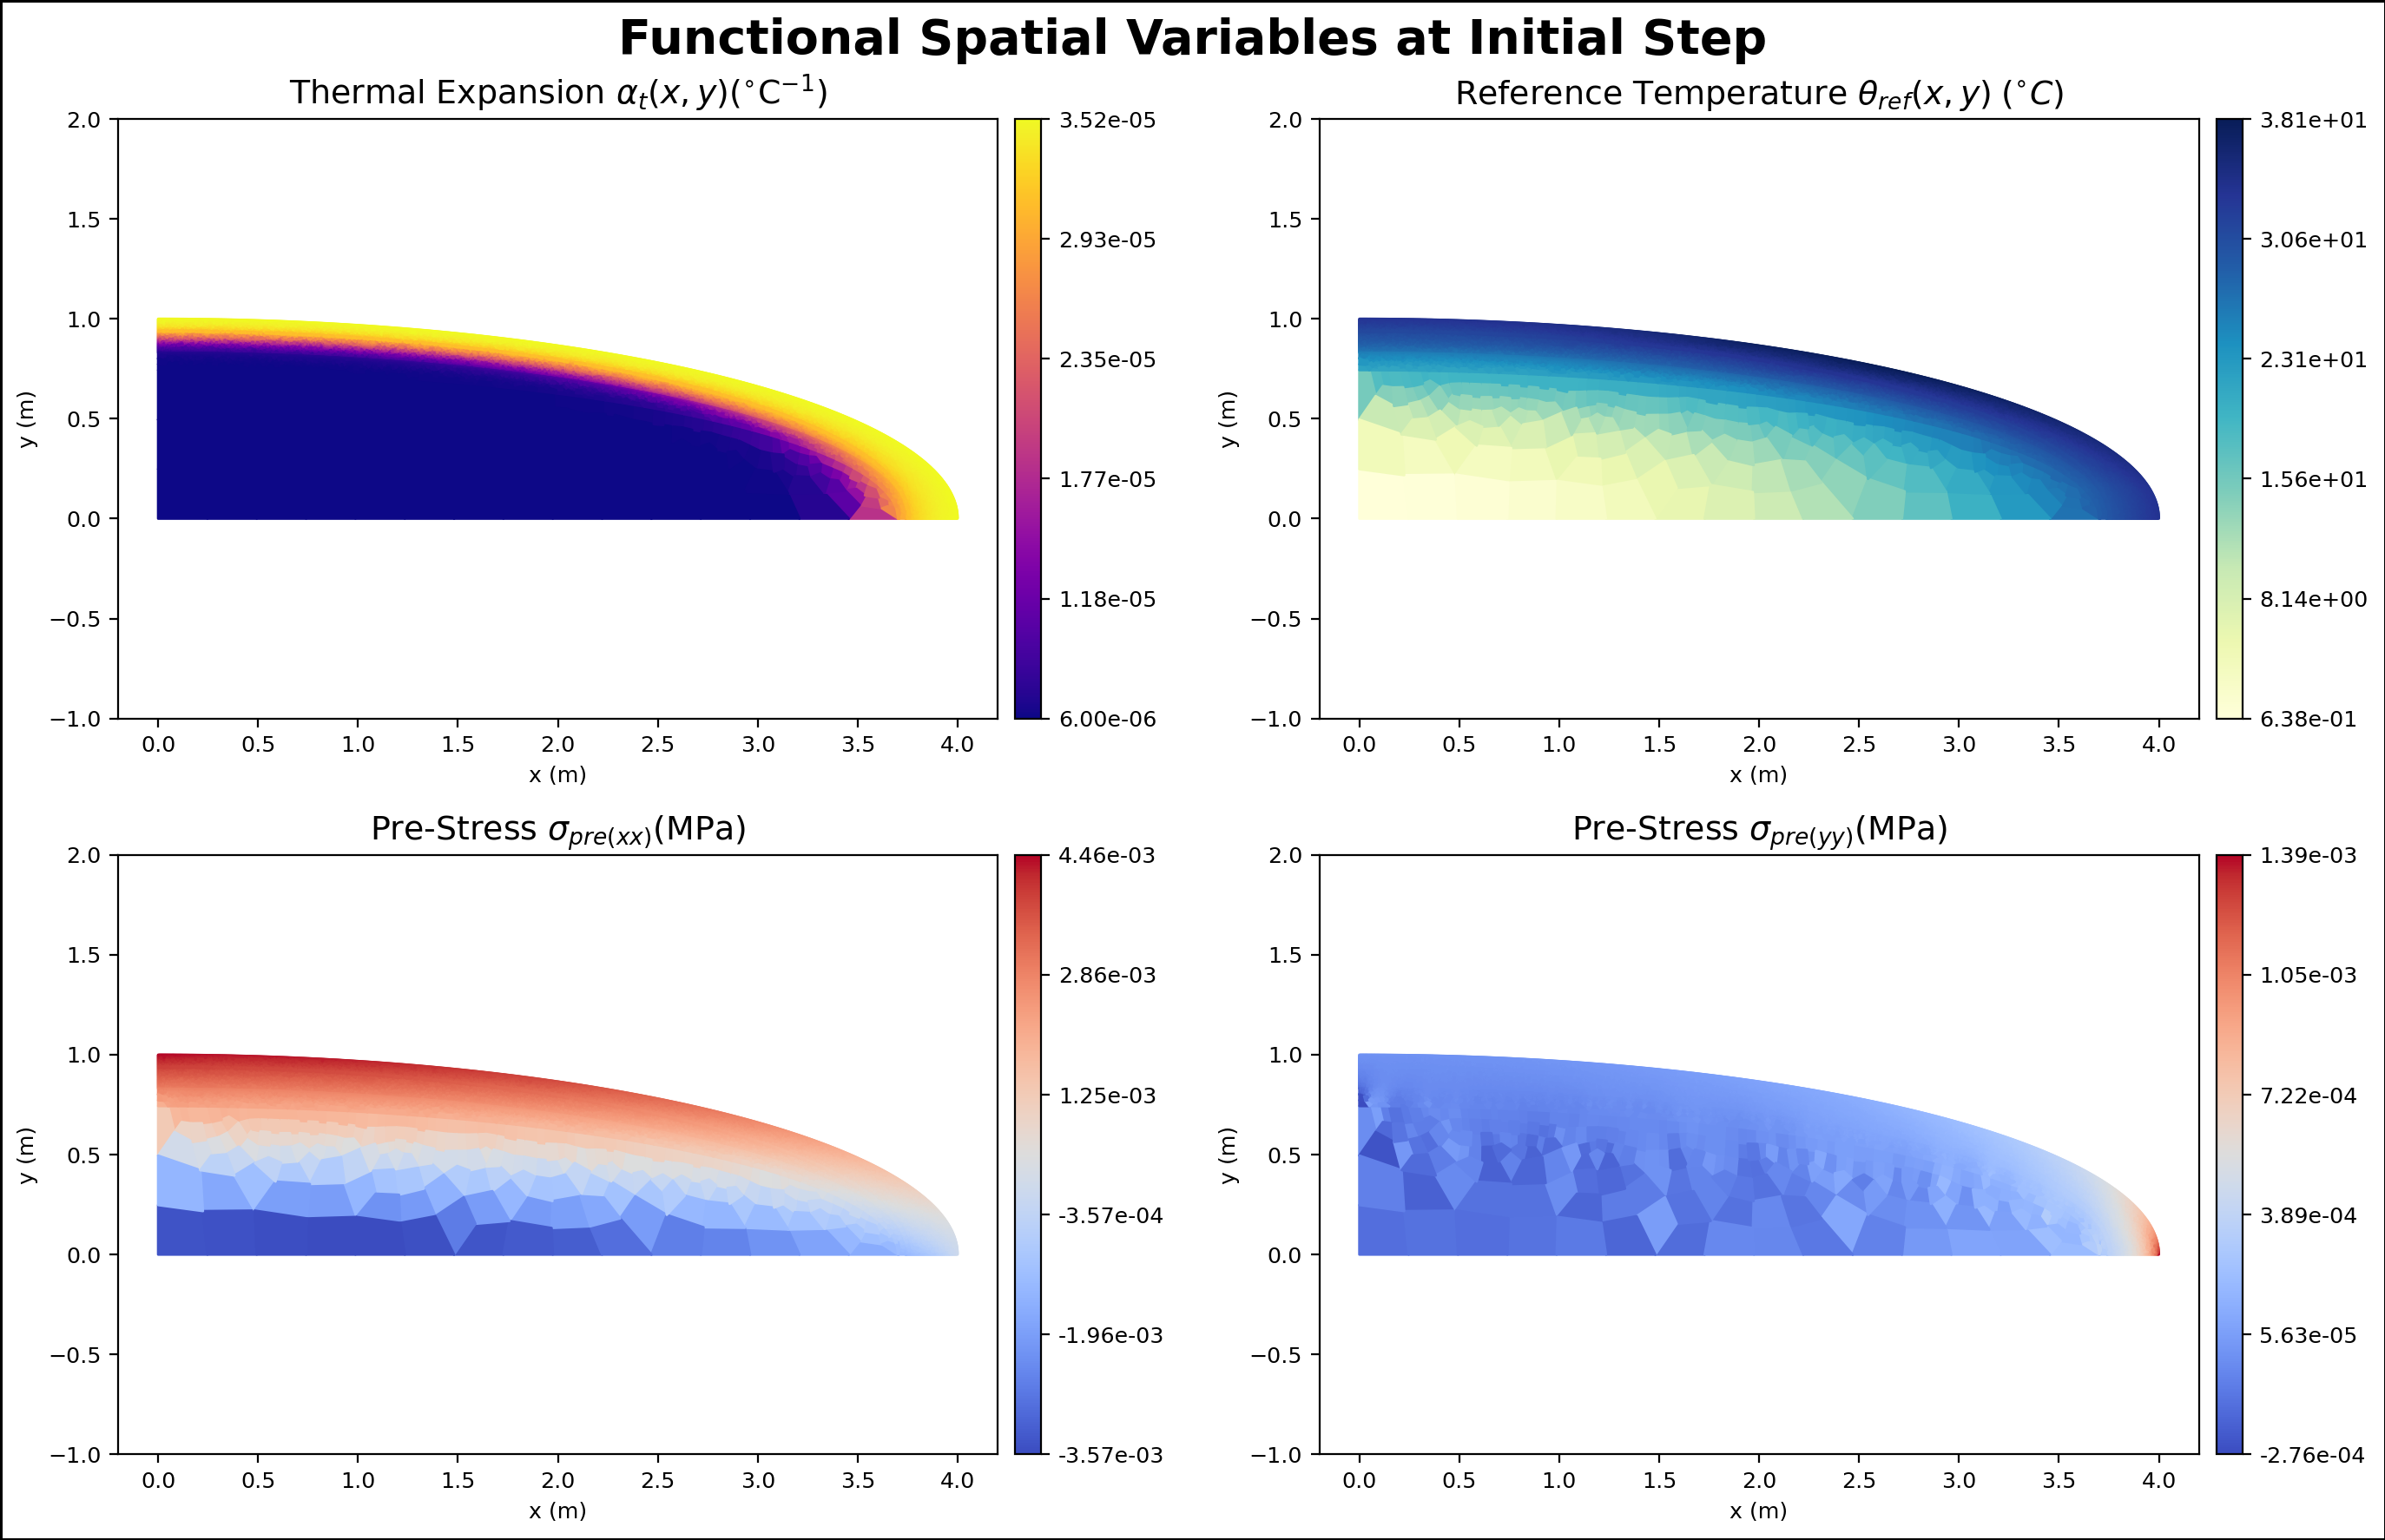

In [7]:



nr, nc = 2, 2  # 子圖數量設定
n_vars = len(elet_vars)
step = 1     # 固定時間點
param_idx_list = range(n_vars)  # 要畫哪些變數（你也可以自訂 list）
color_maps = [
    'plasma',    # Thermal Expansion：低對比但感知一致，色調柔和不刺眼
    'YlGnBu',     # Reference Temperature：黃→綠→藍，適合表示冷熱變化且不突兀
    'coolwarm',   # Pre stress xx：保留對稱 colormap（張壓皆清楚）
    'coolwarm'         # Pre stress yy：藍白紅，標準對稱 colormap 表現清楚
]

e_notations=[True,True,True,True,True]

fig, axes = plt.subplots(nr, nc, figsize=(nc * 7, nr * 4.5), dpi=200)
if nr * nc == 1:
    axes = [axes]
else:
    axes = axes.flatten()

fig.suptitle(
    f"Functional Spatial Variables at Initial Step",
    fontsize=20, fontweight="bold"
)

for i, idx in enumerate(param_idx_list):
    vmin = elet_vars[param_idx_list[i]][-1].min()
    vmax = elet_vars[param_idx_list[i]][-1].max()
    var = elet_vars[idx][step]
    showEltPlot(
        nodes, global_connection, var,
        titlelabel=[elt_var_labels[idx][0], elt_var_labels[idx][1]],
        size=[6, 8], ax = axes[i], p_ext=[0.05, 1],
        colormap=color_maps[i], e_notation=e_notations[i],
        assign_bar_range=[vmin, vmax],
        x_unit=r'x (m)', y_unit=r'y (m)',
        font_adjust=1.3
    )

plt.tight_layout()
plt.subplots_adjust(top=0.915)  # 留空間給 suptitle
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1.2)
plt.savefig('C:/Users/aasam/Desktop/thermal_report/Figs/weeks_thermal_elastic/model_2_Initial_set_up.png')
plt.savefig('C:/Users/aasam/Desktop/thermal_report/svgFigs/weeks_thermal_elastic/model_2_Initial_set_up.svg')
plt.show()

In [8]:
output_list_weak_Gc=['simulation_files2/No1_0p95_2.e','simulation_files2/No2_0p98_2.e']
output_list_initd=['simulation_files2/No1_inidR0p05_2.e','simulation_files2/No2_inidR0p02_2.e']

output_list_no_defects=[['simulation_files2/No_defects.e'],[r"No Defect"]]
output_list_weak_Gc = [
    ['simulation_files2/No1_0p95_2.e','simulation_files2/No2_0p98_2.e'],
    [
        r"Weakened $G_c$ Zone at Depth $\approx 0.05\,R_d$",
        r"Weakened $G_c$ Zone at Depth $\approx 0.02\,R_d$"
    ]
]

output_list_initd = [
    ['simulation_files2/No1_inidR0p05_2.e','simulation_files2/No2_inidR0p02_2.e',
     'simulation_files2/No3_inid_vert8_2.e','simulation_files2/No4_inid_vert12_2.e'],
    [
        r"Prescribed Damage at Depth $\approx 0.05\,R_d$",
        r"Prescribed Damage at Depth $\approx 0.02\,R_d$",
        r"Aligned Initial Cracks (Type 1)",
        r"Aligned Initial Cracks (Type 2)"
    ]
]

output_list=[output_list_weak_Gc[0]+output_list_initd[0],output_list_weak_Gc[1]+output_list_initd[1]]
node_variable_idx=[1, 2 ,3 ,4]
node_var_labels=[[r"Temperature $\theta\;(^{\circ}C)$", ""],
                 [r"Phase Field Fracture Damage", ""],
                 [r"Displacement $u_x$ (m)", ""],
                 [r"Displacement $u_y$ (m)", ""]]

element_variable_idx=[3,]#12]
elt_var_labels=[[r"Energy Release Rate $G_c(x,y)$ MPa $\cdot$m", ""],
                ]
output_list

[['simulation_files2/No1_0p95_2.e',
  'simulation_files2/No2_0p98_2.e',
  'simulation_files2/No1_inidR0p05_2.e',
  'simulation_files2/No2_inidR0p02_2.e',
  'simulation_files2/No3_inid_vert8_2.e',
  'simulation_files2/No4_inid_vert12_2.e'],
 ['Weakened $G_c$ Zone at Depth $\\approx 0.05\\,R_d$',
  'Weakened $G_c$ Zone at Depth $\\approx 0.02\\,R_d$',
  'Prescribed Damage at Depth $\\approx 0.05\\,R_d$',
  'Prescribed Damage at Depth $\\approx 0.02\\,R_d$',
  'Aligned Initial Cracks (Type 1)',
  'Aligned Initial Cracks (Type 2)']]

In [9]:
#nodes, connect_components, global_connection, node_vars, elet_vars,times=read_vars(e_name, node_variable_idx, element_variable_idx)
profiles = [read_vars(e_name, node_variable_idx, element_variable_idx) for e_name in output_list[0]]

['time_whole', 'eb_status', 'eb_prop1', 'ns_status', 'ns_prop1', 'ss_status', 'ss_prop1', 'coordx', 'coordy', 'eb_names', 'ns_names', 'ss_names', 'coor_names', 'node_num_map', 'connect1', 'connect2', 'elem_num_map', 'elem_ss1', 'side_ss1', 'elem_ss2', 'side_ss2', 'elem_ss3', 'side_ss3', 'elem_ss4', 'side_ss4', 'elem_ss5', 'side_ss5', 'node_ns1', 'node_ns2', 'node_ns3', 'node_ns4', 'node_ns5', 'name_nod_var', 'vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'name_elem_var', 'vals_elem_var1eb1', 'vals_elem_var2eb1', 'vals_elem_var3eb1', 'vals_elem_var4eb1', 'vals_elem_var5eb1', 'vals_elem_var6eb1', 'vals_elem_var7eb1', 'vals_elem_var8eb1', 'vals_elem_var9eb1', 'vals_elem_var10eb1', 'vals_elem_var11eb1', 'vals_elem_var12eb1', 'vals_elem_var13eb1', 'vals_elem_var14eb1', 'vals_elem_var15eb1', 'vals_elem_var16eb1', 'vals_elem_var17eb1', 'vals_elem_var18eb1', 'vals_elem_var19eb1', 'vals_elem_var20eb1', 'vals_elem_var21eb1', 'vals_elem_var22eb1', 'vals_elem_var23eb1', 'vals_

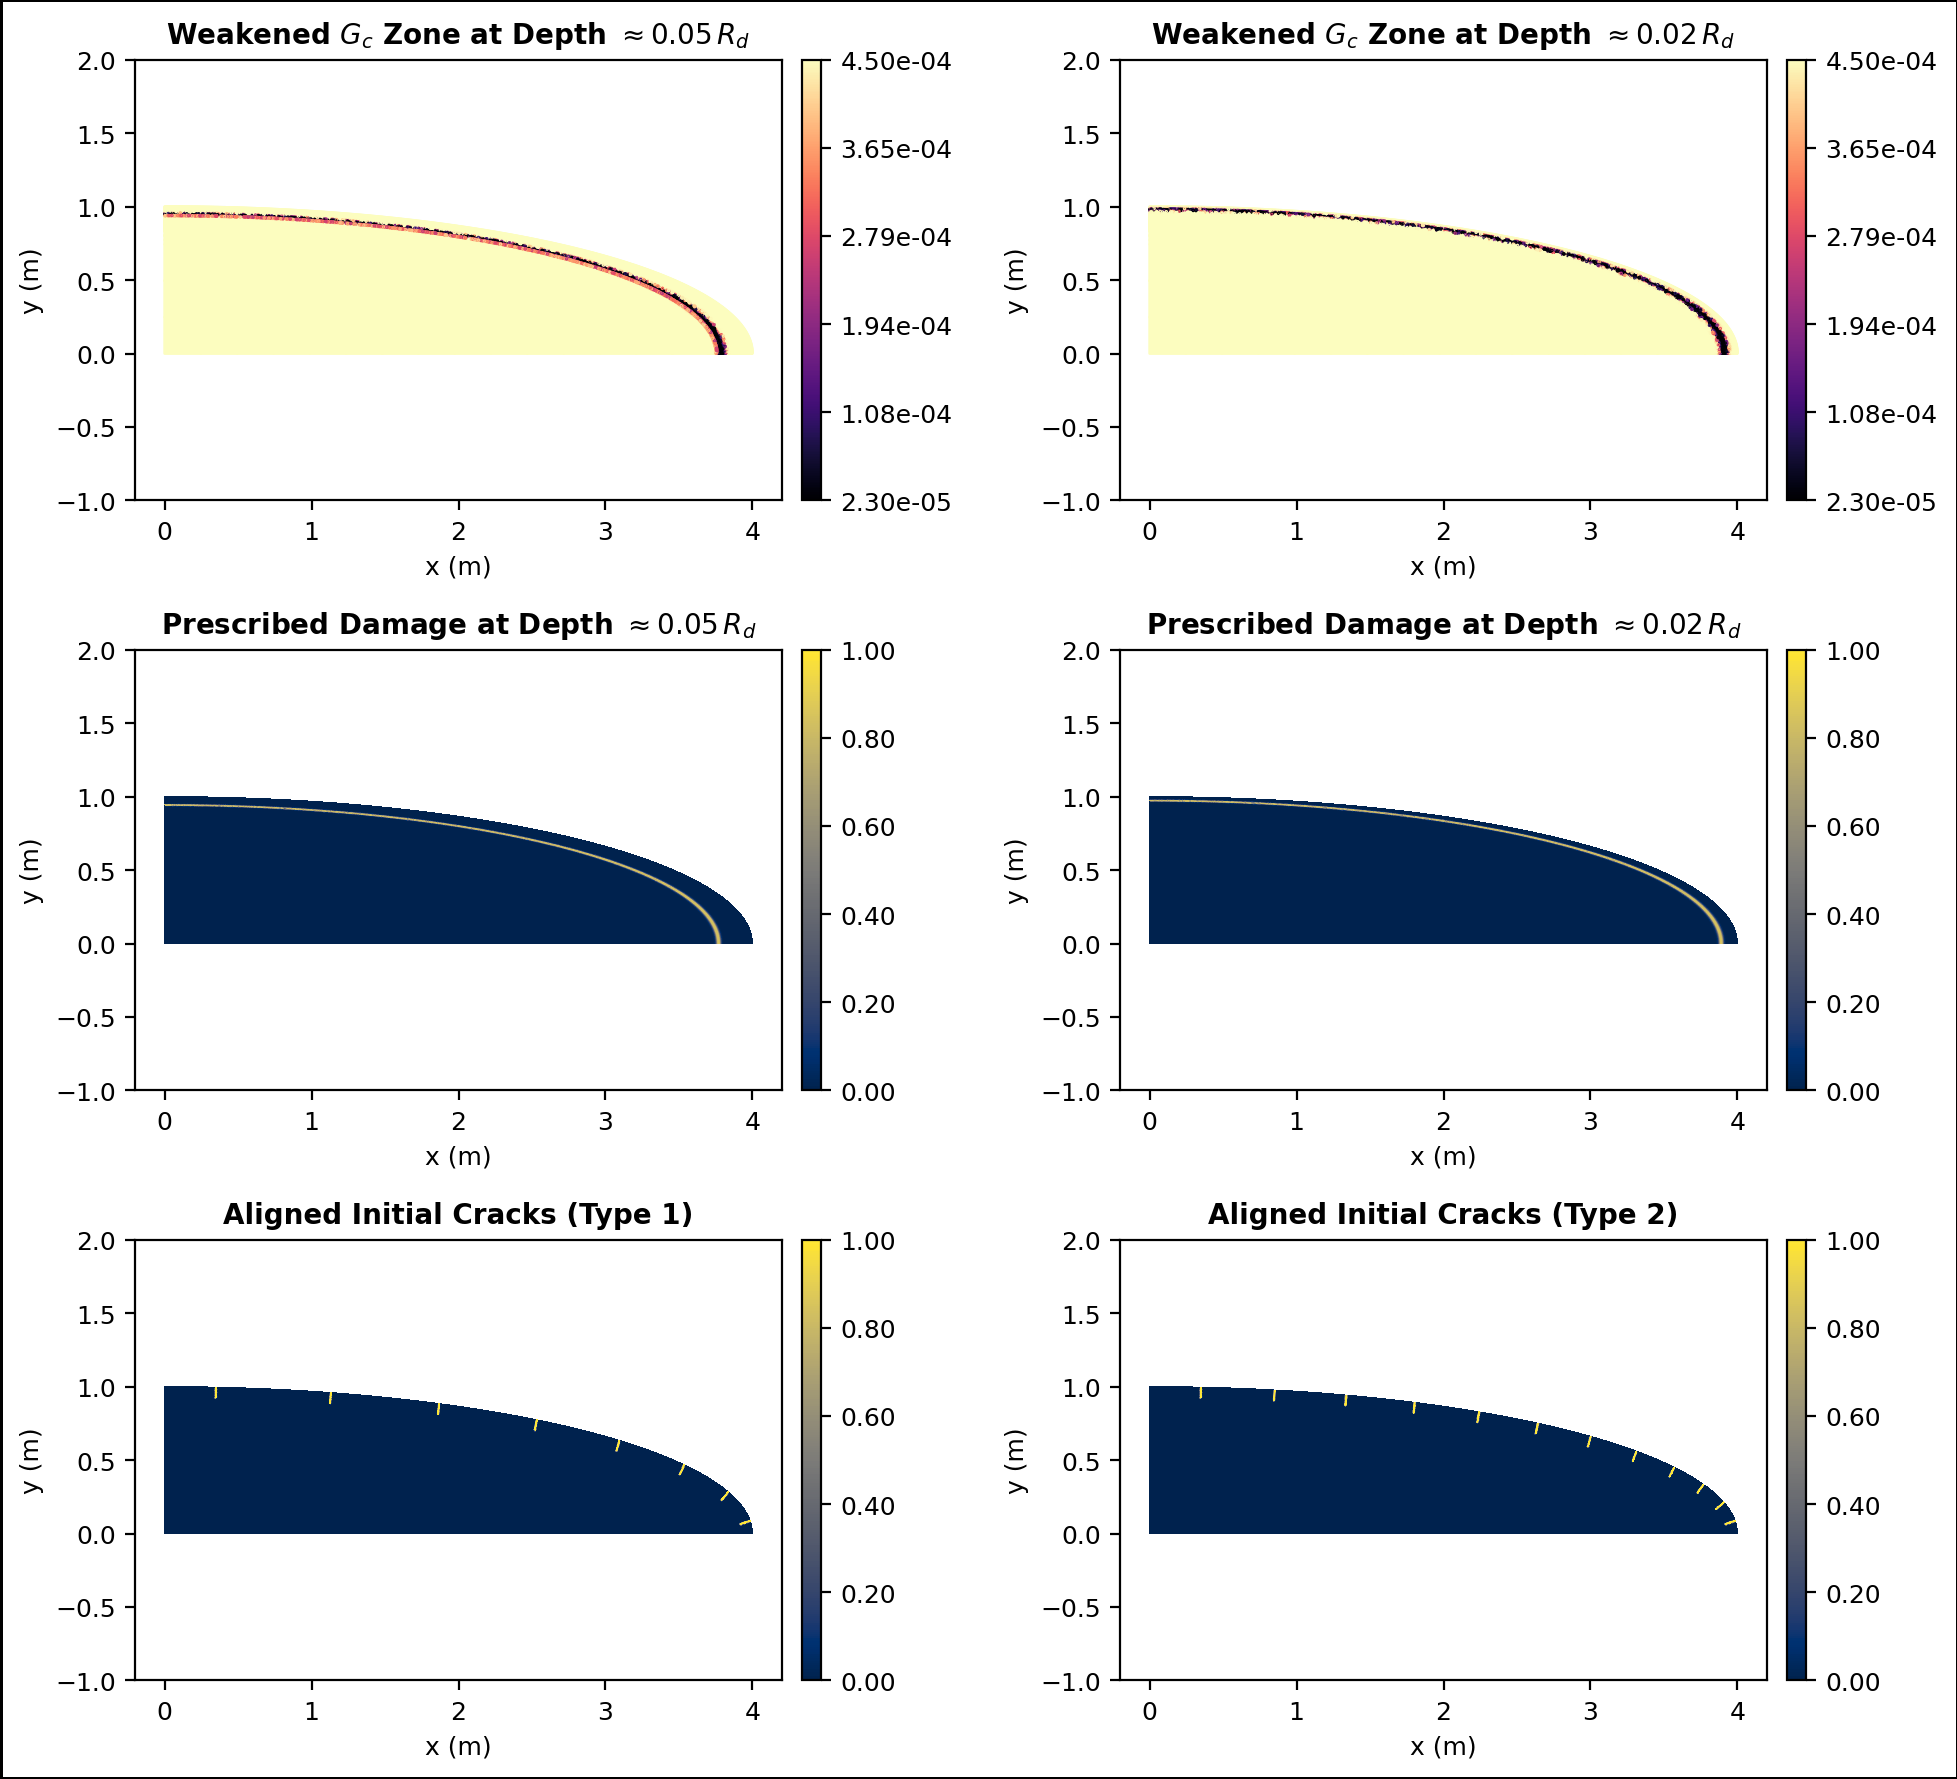

In [10]:
nr, nc = 3, 2

step = 0

fig, axes = plt.subplots(nr, nc, figsize=(nc * 5, nr * 3), dpi=200)
axes = axes.flatten()

# 先取得色階範圍（從任一模型中抓即可）


# 注意：跳過 No Defect（從 profile[1:] 開始），對應 models[1:]
for i, (profile, model_name) in enumerate(zip(profiles, output_list[1])):
    nodes, connect_components, global_connection, node_vars, elet_vars, times = profile
    ax = axes[i]
    if i<2:
        param_idx = 0
        vmin = elet_vars[param_idx].min()
        vmax = elet_vars[param_idx].max()
        showEltPlot(
            nodes, global_connection, elet_vars[param_idx][step],
            titlelabel=["", elt_var_labels[param_idx][1]],
            size=[6, 6], ax=ax, p_ext=[0.05, 1],
            colormap='magma', e_notation=True,
            assign_bar_range=[vmin, vmax],
            x_unit=r'x (m)', y_unit=r'y (m)',
            font_adjust=1.5,manual_assign_range=True,x_mmax=4,x_mmin=0, y_mmax=1,y_mmin=0
        )
    else:
        param_idx = 1
        vmin = node_vars[param_idx].min()
        vmax = node_vars[param_idx].max()
        showNodePlot(nodes, global_connection, node_vars[param_idx][step],
            titlelabel=["", node_var_labels[param_idx][1]],
            size=[6, 6], ax=ax, p_ext=[0.05, 1],
            colormap='cividis', e_notation=False,
            assign_bar_range=[vmin, vmax],
            x_unit=r'x (m)', y_unit=r'y (m)',
            font_adjust=1.5,manual_assign_range=True,x_mmax=4,x_mmin=0, y_mmax=1,y_mmin=0)
    ax.set_title(model_name, fontsize=10, fontweight="bold")
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1.2)

plt.tight_layout()
plt.savefig('C:/Users/aasam/Desktop/thermal_report/Figs/weeks_thermal_elastic/model2_Initial_defects.png')
plt.savefig('C:/Users/aasam/Desktop/thermal_report/svgFigs/weeks_thermal_elastic/model2_Initial_defects.svg')
plt.show()


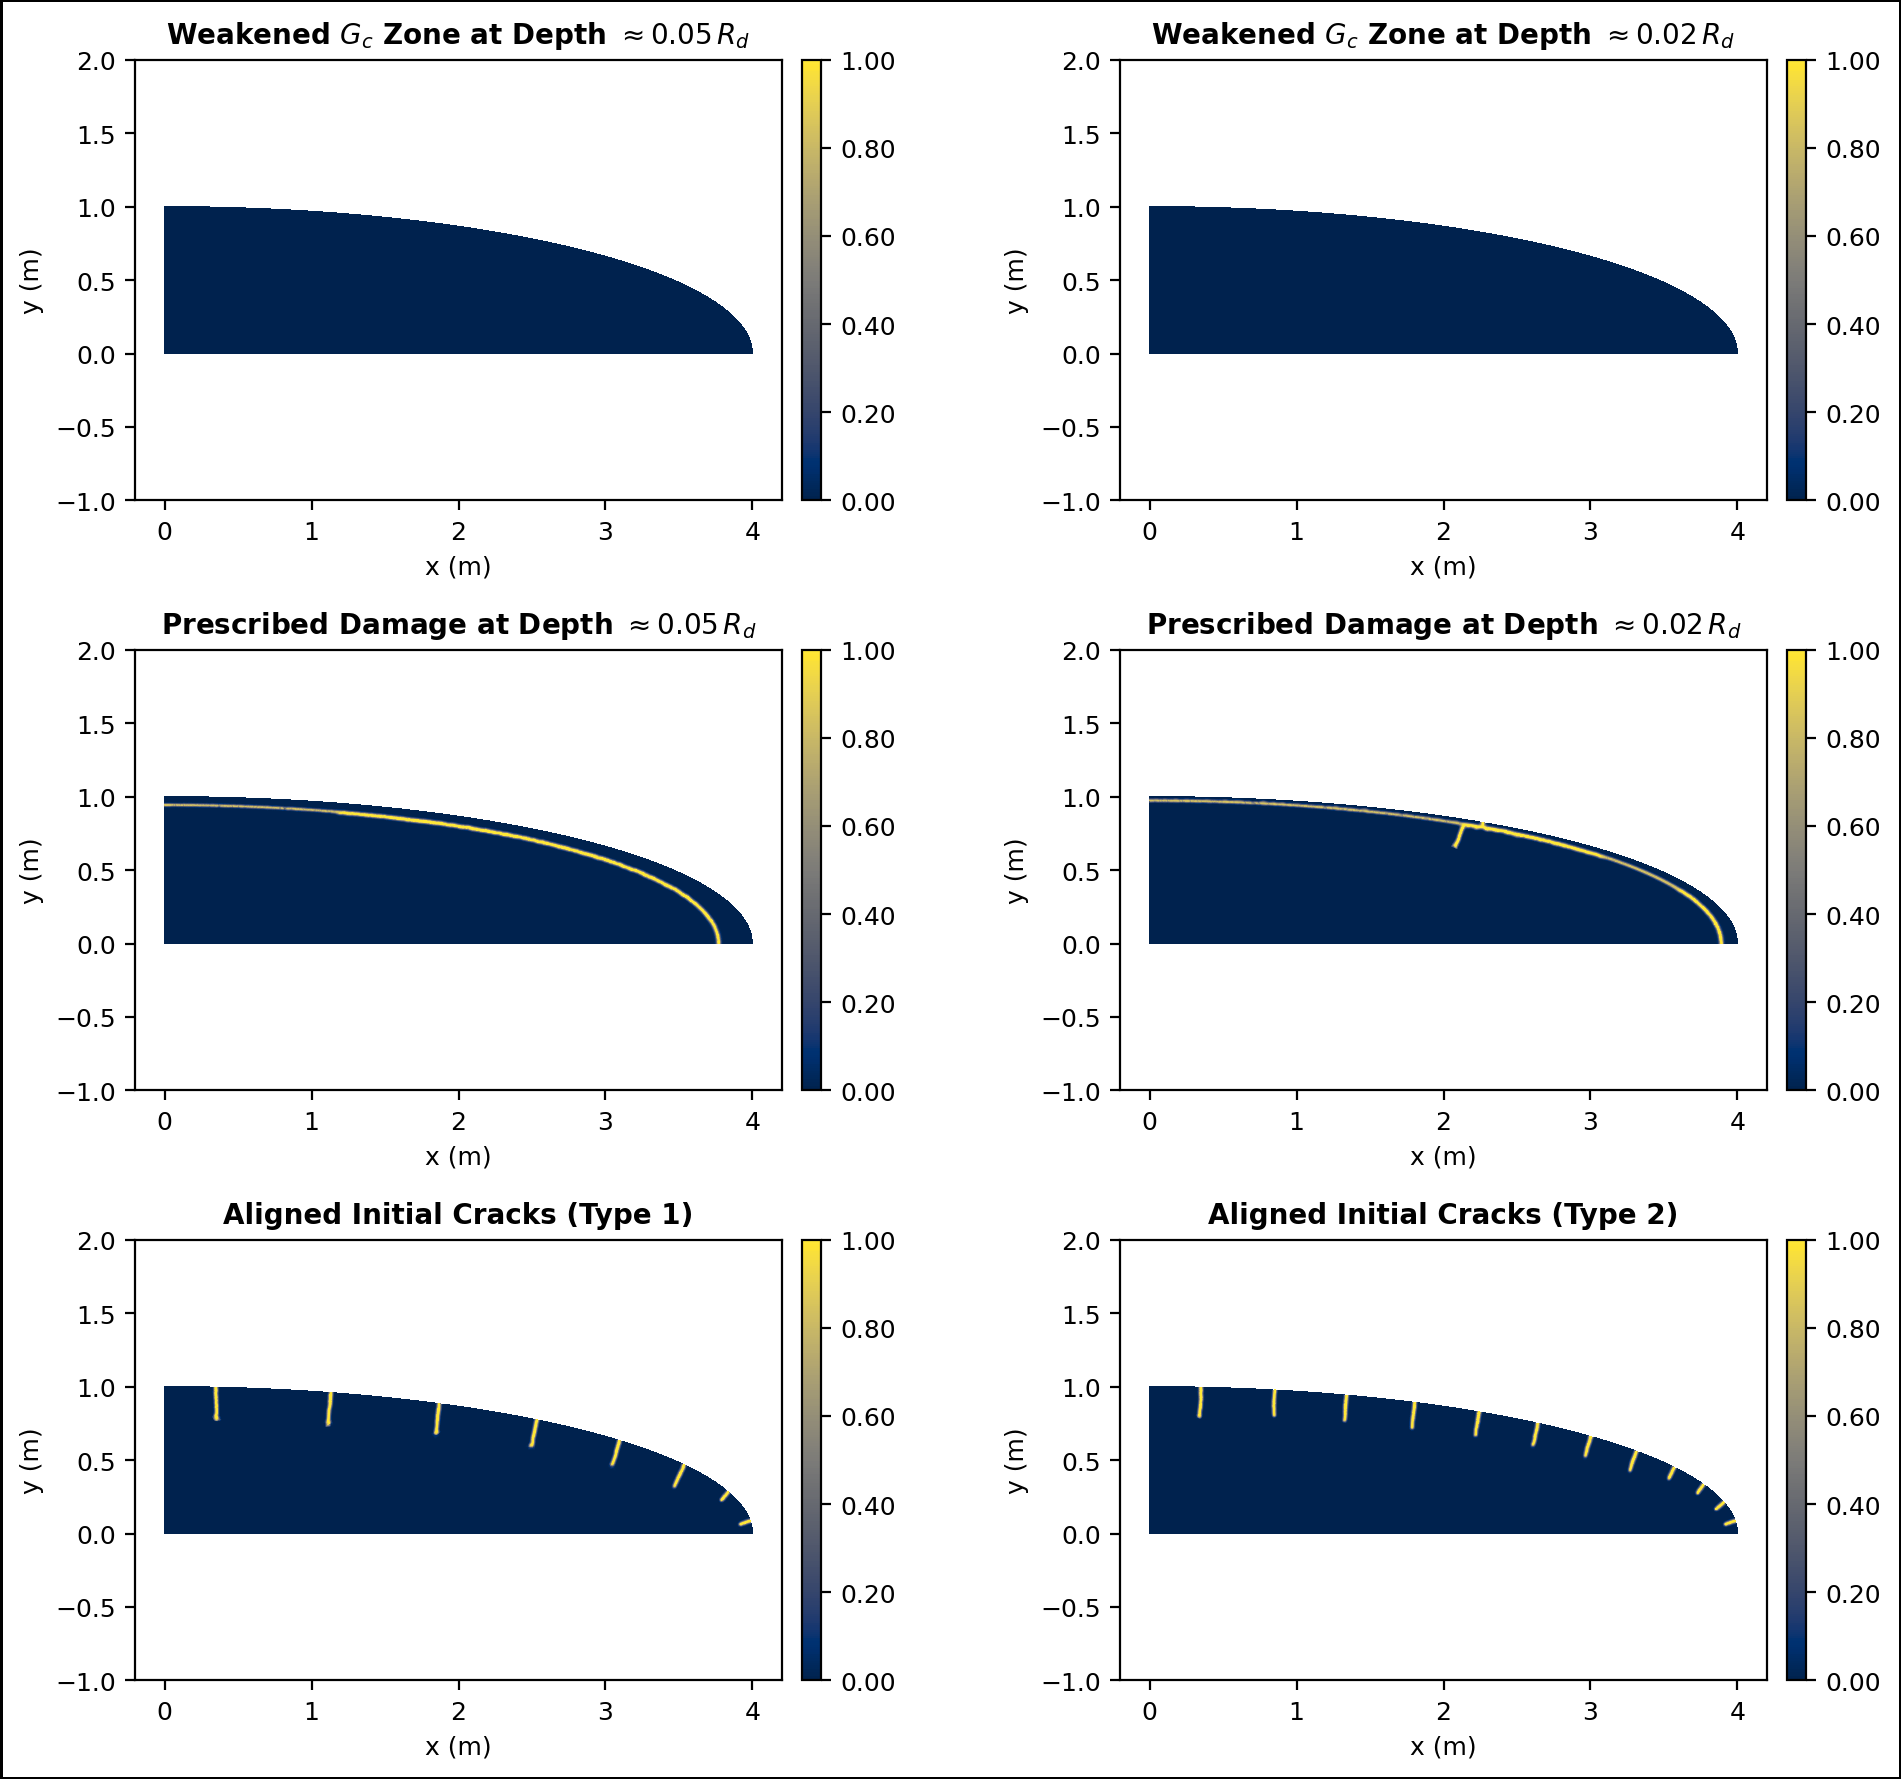

In [22]:
nr, nc = 3, 2
param_idx = 1
step = -1

fig, axes = plt.subplots(nr, nc, figsize=(nc * 5, nr * 3), dpi=200)
axes = axes.flatten()



# 注意：跳過 No Defect（從 profile[1:] 開始），對應 models[1:]
for i, (profile, model_name) in enumerate(zip(profiles, output_list[1])):

    nodes, connect_components, global_connection, node_vars, elet_vars, times = profile
        # 先取得色階範圍（從任一模型中抓即可）
    vmin = 0#node_vars[param_idx].min()
    vmax = 1#node_vars[param_idx].max()
    ax = axes[i]
    dispx=node_vars[2][step]
    dispy=node_vars[3][step]
    deform_nodes=nodes +np.stack([dispx,dispy]).T
    showNodePlot(
        deform_nodes, global_connection, node_vars[param_idx][step],
        titlelabel=["", node_var_labels[param_idx][1]],
        size=[6, 6], ax=ax, p_ext=[0.05, 1],
        colormap='cividis', e_notation=False,
        assign_bar_range=[vmin, vmax],
        x_unit=r'x (m)', y_unit=r'y (m)',
        font_adjust=1.5,manual_assign_range=True,x_mmax=4.0,x_mmin=0, y_mmax=1,y_mmin=0)
    ax.set_title(model_name, fontsize=10, fontweight="bold")
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1.2)

plt.tight_layout()
plt.savefig('C:/Users/aasam/Desktop/thermal_report/Figs/weeks_thermal_elastic/model2_final_failure.png')
plt.savefig('C:/Users/aasam/Desktop/thermal_report/svgFigs/weeks_thermal_elastic/model2_final_failure.svg')
plt.show()

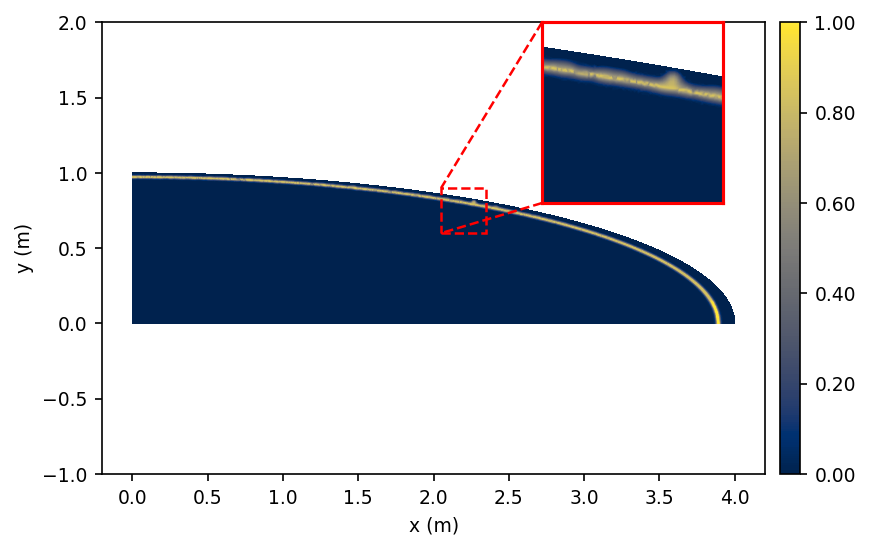

In [65]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
nodes, connect_components, global_connection, node_vars, elet_vars, times = profiles[3]
step=36
param_idx=1
vmax=node_vars[param_idx].max()
vmin=node_vars[param_idx].min()
dispx=node_vars[2][step]
dispy=node_vars[3][step]
deform_nodes=nodes +np.stack([dispx,dispy]).T
# 主圖
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)


showNodePlot(
    deform_nodes, global_connection, node_vars[param_idx][step],
    titlelabel=["", node_var_labels[param_idx][1]],
    size=[6, 6], ax=ax, p_ext=[0.05, 1],
    colormap='cividis', e_notation=False,
    assign_bar_range=[vmin, vmax],
    x_unit=r'x (m)', y_unit=r'y (m)',
    font_adjust=1.5,manual_assign_range=True,x_mmax=4.0,x_mmin=0, y_mmax=1,y_mmin=0)

# 加時間標題
#plt.suptitle(f"Time: {times[step]:.4f}", fontsize=10, fontweight="bold")


x1, x2, y1, y2 = 2.05, 2.35, 0.6, 0.9  # subregion of the original image
# 小圖（inset）
axins = ax.inset_axes([0.3, 0.6, 1.0, 0.4])  # 位置固定
showNodePlot(
    deform_nodes, global_connection, node_vars[param_idx][step],
    titlelabel=["", ""],
    size=[0, 0], ax=axins, p_ext=[0, 0],  # ✅ 禁止擴張
    colormap='cividis', e_notation=True,
    assign_bar_range=[vmin, vmax],
    x_unit="", y_unit="", font_adjust=0,show_cbar=False
)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for spine in axins.spines.values():
    spine.set_edgecolor("red")   # 顏色
    spine.set_linewidth(1.5)       # 線寬
    spine.set_linestyle("-")       # 線型（可選）


mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="red", lw=1.2, ls='--')
plt.savefig('C:/Users/aasam/Desktop/thermal_report/Figs/weeks_thermal_elastic/model2_before.png')
plt.savefig('C:/Users/aasam/Desktop/thermal_report/svgFigs/weeks_thermal_elastic/model2_before.svg')
#plt.subplots_adjust(top=1.3)
plt.show()


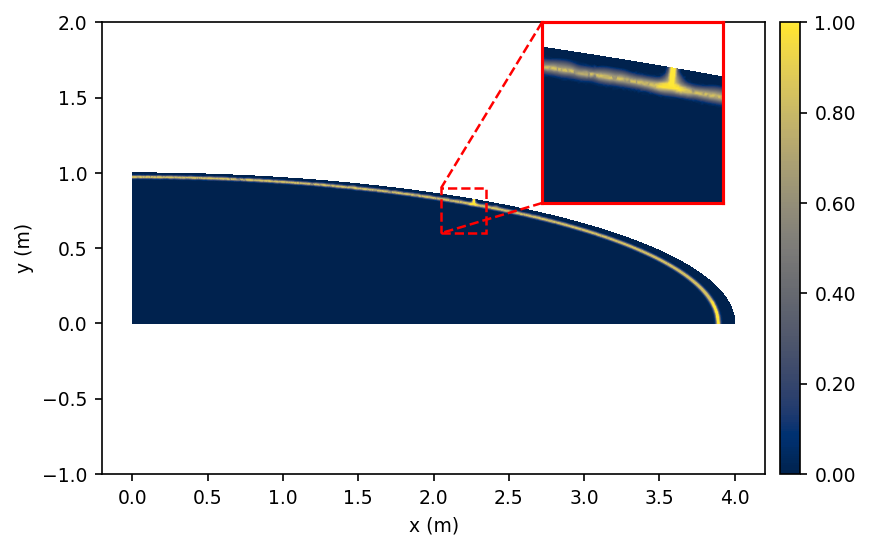

In [66]:
nodes, connect_components, global_connection, node_vars, elet_vars, times = profiles[3]
step=37
param_idx=1
vmax=node_vars[param_idx].max()
vmin=node_vars[param_idx].min()
dispx=node_vars[2][step]
dispy=node_vars[3][step]
deform_nodes=nodes +np.stack([dispx,dispy]).T
# 主圖
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)


showNodePlot(
    deform_nodes, global_connection, node_vars[param_idx][step],
    titlelabel=["", node_var_labels[param_idx][1]],
    size=[6, 6], ax=ax, p_ext=[0.05, 1],
    colormap='cividis', e_notation=False,
    assign_bar_range=[vmin, vmax],
    x_unit=r'x (m)', y_unit=r'y (m)',
    font_adjust=1.5,manual_assign_range=True,x_mmax=4.0,x_mmin=0, y_mmax=1,y_mmin=0)

# 加時間標題
#plt.suptitle(f"Time: {times[step]:.4f}", fontsize=10, fontweight="bold")


x1, x2, y1, y2 = 2.05, 2.35, 0.6, 0.9  # subregion of the original image
# 小圖（inset）
axins = ax.inset_axes([0.3, 0.6, 1.0, 0.4])  # 位置固定
showNodePlot(
    deform_nodes, global_connection, node_vars[param_idx][step],
    titlelabel=["", ""],
    size=[0, 0], ax=axins, p_ext=[0, 0],  # ✅ 禁止擴張
    colormap='cividis', e_notation=True,
    assign_bar_range=[vmin, vmax],
    x_unit="", y_unit="", font_adjust=0,show_cbar=False
)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for spine in axins.spines.values():
    spine.set_edgecolor("red")   # 顏色
    spine.set_linewidth(1.5)       # 線寬
    spine.set_linestyle("-")       # 線型（可選）


mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="red", lw=1.2, ls='--')
plt.savefig('C:/Users/aasam/Desktop/thermal_report/Figs/weeks_thermal_elastic/model2_after.png')
plt.savefig('C:/Users/aasam/Desktop/thermal_report/svgFigs/weeks_thermal_elastic/model2_after.svg')
#plt.subplots_adjust(top=1.3)
plt.show()

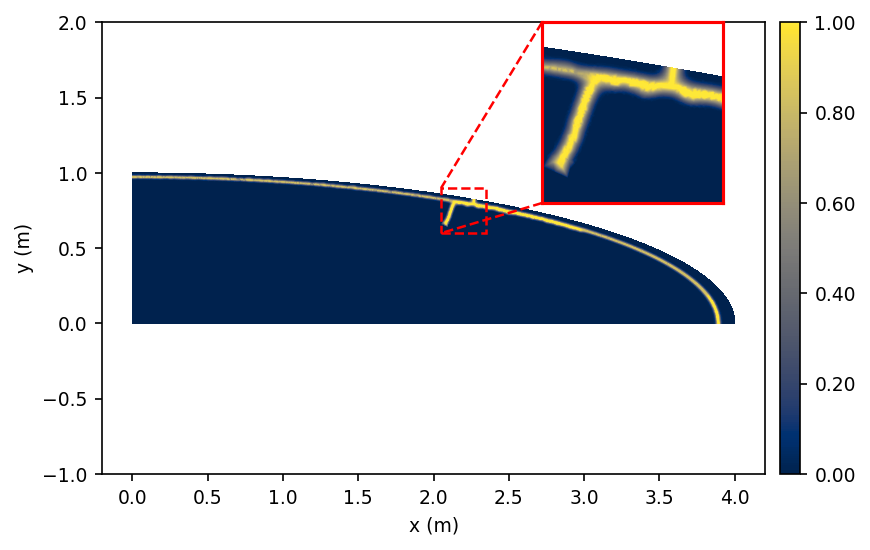

In [69]:
nodes, connect_components, global_connection, node_vars, elet_vars, times = profiles[3]
step=100
param_idx=1
vmax=node_vars[param_idx].max()
vmin=node_vars[param_idx].min()
dispx=node_vars[2][step]
dispy=node_vars[3][step]
deform_nodes=nodes +np.stack([dispx,dispy]).T
# 主圖
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)


showNodePlot(
    deform_nodes, global_connection, node_vars[param_idx][step],
    titlelabel=["", node_var_labels[param_idx][1]],
    size=[6, 6], ax=ax, p_ext=[0.05, 1],
    colormap='cividis', e_notation=False,
    assign_bar_range=[vmin, vmax],
    x_unit=r'x (m)', y_unit=r'y (m)',
    font_adjust=1.5,manual_assign_range=True,x_mmax=4.0,x_mmin=0, y_mmax=1,y_mmin=0)

# 加時間標題
#plt.suptitle(f"Time: {times[step]:.4f}", fontsize=10, fontweight="bold")


x1, x2, y1, y2 = 2.05, 2.35, 0.6, 0.9  # subregion of the original image
# 小圖（inset）
axins = ax.inset_axes([0.3, 0.6, 1.0, 0.4])  # 位置固定
showNodePlot(
    deform_nodes, global_connection, node_vars[param_idx][step],
    titlelabel=["", ""],
    size=[0, 0], ax=axins, p_ext=[0, 0],  # ✅ 禁止擴張
    colormap='cividis', e_notation=True,
    assign_bar_range=[vmin, vmax],
    x_unit="", y_unit="", font_adjust=0,show_cbar=False
)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for spine in axins.spines.values():
    spine.set_edgecolor("red")   # 顏色
    spine.set_linewidth(1.5)       # 線寬
    spine.set_linestyle("-")       # 線型（可選）


mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="red", lw=1.2, ls='--')
plt.savefig('C:/Users/aasam/Desktop/thermal_report/Figs/weeks_thermal_elastic/model2_after_ext.png')
plt.savefig('C:/Users/aasam/Desktop/thermal_report/svgFigs/weeks_thermal_elastic/model2_after_ext.svg')
#plt.subplots_adjust(top=1.3)
plt.show()

In [194]:
step

276